# Catalog utilities
The following snippets will acomplish the goals:
1. Catalog propagation to a given date.
2. Catalog selection of stars with a VMag lesser than a given value.
3. Generate a guide star catalog with the angular distance to each other.
4. Plot the guide stars


## Catalog propagation to a given data
### Input parameters
    - (-i) *Hipparcos catalog file path*: can be downloaded from https://cdsarc.u-strasbg.fr/viz-bin/Cat
    - (-d) *Date to propagate the catalog to*: e.g. "2020 1 1 12.00"
    - (-o) *File name of the CSV file with propagated catalog*

In [67]:
from typing import NamedTuple
import math
import numpy as np

class CatEntry(NamedTuple):
    """Represents a catalog entry"""
    starname: str
    catalog: str
    starnumber: int
    ra: float
    dec: float
    promora: float
    promodec: float
    parallax: float
    radialvelocity: float
    vmag: float


def convertRADEC(ra, dec):
    """Converts the given ra and dec to its cartesian coordinates"""
    r = 1
    x = r * math.sin(np.deg2rad(dec)) * math.cos(np.deg2rad(ra))
    y = r * math.sin(np.deg2rad(dec)) * math.sin(np.deg2rad(ra))
    z = r * math.cos(np.deg2rad(dec))

    return [x, y, z]


In [11]:
def data_complete(star):
    """Checks if the star has the required data"""
    try:
        float(star[8])
    except ValueError:
        return False

    return True


def deg_to_time(degress):
    """Converts a given degrees into time format"""
    decimal_time = deg_to_decimal_time(degress)
    hours = int(decimal_time)
    minutes = (decimal_time*60) % 60
    seconds = (decimal_time*3600) % 60

    return f"{hours} {minutes} {seconds:.2f}"


def deg_to_decimal_time(degrees):
    """Converts a given degrees into decimal time float"""
    return degrees / 15.0


def decimal_time_to_degrees(decimal_time):
    """Converts a given decimal time into degrees"""
    return decimal_time * 15.0


def deg_to_deg_min_sec(degrees):
    """Convert decimal degrees to degress, minutes and seconds"""
    d = int(degrees)
    minutes = int((degrees - d) * 60)
    seconds = (degrees - d - minutes / 60) * 3600

    # Append a '+' for positive degrees
    if d >= 0:
        return f"+{d:02d} {minutes} {seconds:.1f}"

    return f"{d:03d} {minutes} {seconds:.1f}"


## Propagate the Catalog

In [29]:
import csv
from novas import compat as novas

original_catalog_filepath = "hip_main.dat"
converted_catalog_filepath = "./out/hip_main_converted.csv"
convert_date = "2020 1 1 12.00"
date = convert_date.split(' ')
leap_secs = 37
epoc_hip = 2448349.0625
# Date to convert the catalog to
jd_utc = novas.julian_date(int(date[0]), int(date[1]),
                           int(date[2]), float(date[3]))
jd_tt = jd_utc + (leap_secs + 32.184) / 86400
# Read the original catalog content
with open(original_catalog_filepath, 'r') as raw:
    content = [
        [field.strip() for field in line.split('|')]
        for line in raw
    ]
    incomplete_stars = []
for line in content:
    if not data_complete(line):
        incomplete_stars.append(line[1])
        continue
    ra_hours = deg_to_decimal_time(float(line[8]))
    parallax = float(line[11]) if float(line[11]) > 0 else 0.0
    vmag = float(line[5])
    star = novas.make_cat_entry(line[1], "HIP", int(line[1]),
                                float(ra_hours), float(line[9]),
                                float(line[12]), float(line[13]),
                                parallax, 0.0)

    star_con = novas.transform_cat(1, epoc_hip, star, jd_tt, "HP2")
    star_entry = CatEntry(star_con.starname, star_con.catalog,
                          star_con.starnumber, star_con.ra,
                          star_con.dec, star_con.promora,
                          star_con.promodec, star_con.parallax,
                          star_con.radialvelocity, vmag)
# Write new catalog into a file
with open(converted_catalog_filepath, mode='w') as csv_file:
    fieldnames = ['HIP_number', 'ra_degrees', 'dec_degrees',
                  'promora', 'promodec', 'parallax', 'vmag']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for star in converted:
        writer.writerow({
            'HIP_number': star.starnumber,
            'ra_degrees': "{0:.8f}".format(decimal_time_to_degrees(star.ra)),
            'dec_degrees': "{0:.8f}".format(star.dec),
            'promora': "{0:.8f}".format(star.promora),
            'promodec': "{0:.8f}".format(star.promodec),
            'parallax': "{0:.8f}".format(star.parallax),
            'vmag': "{0:.2f}".format(star.vmag),
        })        

## At this point we have a new CSV file with the stars propagated to the date 01/01/2020 at 12:00.


In [52]:
catalog = []
catalog_vmag = []
with open("./out/hip_main_converted.csv", 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count != 0:
            star = CatEntry(row['HIP_number'], "HIP",
                            row['HIP_number'], float(row['ra_degrees']),
                            float(row['dec_degrees']), row['promora'],
                            row['promodec'], row['parallax'],
                            0.0, float(row['vmag']))
            catalog.append(star)
            if float(row['vmag']) < CVmag:
                catalog_vmag.append(star)
        line_count += 1

print("Total number of stars: {}".format(len(catalog)))
print("Total number of stars with Vmag < 4.5: {}".format(len(catalog_vmag)))

Total number of stars: 117954
Total number of stars with Vmag < 4.5: 907


## There are some stars with incomplete data which we are not going to include in our new propagated catalog.
### The total number and their identifier in the HIP catalog is shown below.

In [16]:
print("There are {} incomplete stars.".format(len(incomplete_stars)))
print(incomplete_stars)

There are 263 incomplete stars.
['421', '1338', '1902', '2189', '3158', '3482', '3856', '5502', '6132', '7635', '8538', '8713', '8781', '9429', '9867', '10270', '10659', '10689', '11692', '11829', '12103', '13235', '14275', '14277', '14951', '16216', '16218', '17201', '18045', '18377', '18404', '19424', '19708', '20488', '21185', '120411', '22992', '23299', '24042', '24078', '24360', '24539', '24648', '25050', '25105', '120412', '25836', '27262', '27464', '27981', '28121', '29119', '31067', '31132', '31153', '31157', '31437', '31500', '31825', '31999', '32000', '32340', '32914', '34226', '34467', '34716', '34836', '35195', '35311', '35571', '35964', '36007', '36109', '36609', '36642', '36649', '37417', '38256', '38398', '38562', '38821', '39753', '40272', '41110', '41397', '41405', '41884', '43283', '43329', '43344', '43708', '43820', '43946', '44039', '44197', '45108', '45109', '45205', '45792', '46500', '47386', '48307', '48645', '48665', '50572', '50640', '50751', '51426', '51496', 

## Guide star Catalog
### Having a propagated catalog, we can create a relation between a set of stars (CVmag < 4.5) and write down their angular distance


In [53]:
import math
import itertools

guide_catalog = []
CVmag = 4.5
FOV_h = 2 * 14.455
FOV_v = 2 * 10.94
FOV = math.sqrt(FOV_h**2 + FOV_v**2)

for a, b in itertools.combinations(catalog_vmag, 2):
    a_car = convertRADEC(a.ra, a.dec + 90)
    b_car = convertRADEC(b.ra, b.dec + 90)
    dab = math.degrees(math.acos(a_car[0] * b_car[0] +
                                 a_car[1] * b_car[1] +
                                 a_car[2] * b_car[2]))

    if dab < FOV:
        guide_catalog.append([a.starnumber, b.starnumber, dab])

guide_catalog.sort(key=lambda x: x[2])


In [61]:
# size of the guide star Catalog
print(len(guide_catalog))

43552


## Plot the guide stars

In [70]:
# Save the propagated catalog in a dictionary to access stars data quickly
hip_catalog_dic = {}
with open(converted_catalog_filepath, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count != 0:
            hip_catalog_dic[row['HIP_number']] = [
                row['ra_degrees'],
                row['dec_degrees'],
                row['promora'],
                row['promodec'],
                row['parallax'],
                row['vmag']
            ]
        line_count += 1    

In [71]:
# Get the unique stars from the guide_catalog
guide_stars = [set(x) for x in zip(*guide_catalog)][0]

# Build their cartesian coordinates to plot them
stars_car = []
for star in guide_stars:
    star_ra = float(hip_catalog_dic[star][0])
    star_dec = float(hip_catalog_dic[star][1])
    star_car = convertRADEC(star_ra, star_dec + 90)
    stars_car.append(star_car)

In [72]:
# Check the number of guide stars
print(len(guide_stars))
print(len(stars_car))

904
904


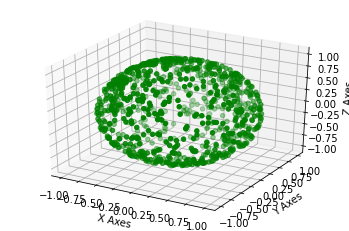

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.figure()
ax = plt.axes(projection="3d")
list_zip = [x for x in zip(*stars_car)]
ax.scatter(list_zip[0], list_zip[1], list_zip[2], color='g')
ax.set_xlabel('X Axes')
ax.set_ylabel('Y Axes')
ax.set_zlabel('Z Axes')
plt.show()